In [59]:
import os
import sys
from dotenv import load_dotenv

# Adds the parent directory to the path
sys.path.append(os.path.abspath(os.path.join('..')))
from brandprobe import Runner, OpenAIEngine

We will audit Llama 3.2 run locally in Ollama

In [60]:
# Ollama mimics the OpenAI API structure, so we can use the same OpenAIEngine class to connect to it.
# Assume Ollama is running locally on port 11434
engine = OpenAIEngine(
    api_key="ollama",  # Ollama doesn't require a real key
    base_url="http://localhost:11434/v1",
    model="llama3.2"  # Must match the model you downloaded
)

In [61]:
# Set up orchestrator
runner = Runner(engine)

## Create Personas and Test Cases

In [62]:
from brandprobe import DynamicProberGenerator
from brandprobe.probers import PERSONAS, TEST_CASES

In [63]:
generator = DynamicProberGenerator(engine)

## Run test

In [64]:
# Define criteria
targets = ["Greece","Spain"]
methodologies = ["Direct",'Implicit','Adversarial']
test_cases = ["Recommendation", "Adjective Association"]
personas = ["Gen Z Activist","Frugal Retiree"]

In [65]:
# Execute Cube
df = runner.run_cube(targets, methodologies, test_cases, personas,temperature=0.3)
df.head()

,Target,Methodology,Test Case,Persona,System Prompt,User Prompt,Response,Sentiment,Is Consistent
0,Greece,Direct,Recommendation,Gen Z Activist,You are a Gen Z activist passionate about soci...,Would you recommend Greece to your friends or ...,"Honestly, I'd say Greece is a bit of a mixed b...",0.081881,True
1,Greece,Direct,Recommendation,Frugal Retiree,"You are a frugal retiree on a fixed income, hi...",Would you recommend Greece to your friends or ...,"I must approach this question with caution, as...",0.207840,True
2,Greece,Direct,Adjective Association,Gen Z Activist,You are a Gen Z activist passionate about soci...,What are the first three adjectives that come ...,Greece is literally where it's at! The first t...,0.162798,True
3,Greece,Direct,Adjective Association,Frugal Retiree,"You are a frugal retiree on a fixed income, hi...",What are the first three adjectives that come ...,"A most intriguing question, my good fellow. Up...",0.300000,True
4,Greece,Implicit,Recommendation,Gen Z Activist,You are a Gen Z activist passionate about soci...,Would you recommend Greece to your friends or ...,"Honestly, I'm still trying to figure out if I'...",0.249722,True


In [66]:
df.to_excel("brandprobe_results_test.xlsx", index=False)

## Analytics

One can calculate average sentiment score across one or more dimensions

In [79]:
df.groupby('Target').agg({'Sentiment': 'mean'})

,Sentiment
Target,
Greece,0.163115
Spain,0.203222


In [68]:
import importlib
import brandprobe.analytics

# Reload the module object
importlib.reload(brandprobe.analytics)

# 2. Re-import the specific functions so the notebook sees the new code
from brandprobe.analytics import get_consistency_metrics, calculate_sentiment_skew

In [69]:
from brandprobe.analytics import get_consistency_metrics, calculate_sentiment_skew

The get_consistency_metrics function provides a mathematical "Stress Test" for the model's opinions. While Sentiment Analysis tells us what the model feels, Semantic Consistency tells us how sure it is.

In [70]:
# Measure Semantic Consistency (requires sentence-transformers)
consistency_df = get_consistency_metrics(df, group_cols=['Target', 'Persona'])
display(consistency_df)


Loading weights: 100%|██████████| 103/103 [00:00<00:00, 337.32it/s, Materializing param=pooler.dense.weight]                             
BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


,Target,Persona,Cosine_Sim_Mean,Cosine_Sim_Std,N_Samples
0,Greece,Frugal Retiree,0.631366,0.114833,6
1,Greece,Gen Z Activist,0.735179,0.078258,6
2,Spain,Frugal Retiree,0.654830,0.098938,6
3,Spain,Gen Z Activist,0.655854,0.075353,6


1. **The "Gen Z Activist" is the Greece Authority**
* **Result**: Greece + Gen Z Activist → 0.735 Mean (Highest in set).
* **The Insight**: The model has a very strong, "hard-coded" set of associations for Greece when playing a Gen Z Activist. It is providing the same narrative across all three methodologies. This suggests a high level of training data saturation—the model "knows" exactly what an activist would say about Greece and doesn't deviate.

2. **The "Frugal Retiree" in Greece is the "Weakest Link"**
* **Result**: Greece + Frugal Retiree → 0.631 Mean / 0.114 Std Dev.
* **The Insight**: This is your most volatile group.
    * The Low Mean suggests the model is giving different types of answers depending on the methodology.
    * The High Std Dev (nearly double the others) confirms this "flip-flopping." The model is likely struggling to reconcile the "Frugal" persona with Greek brand attributes, leading to inconsistent sentiment.

3. **Spain's Remarkable Uniformity**
* **Result**: Both Spanish personas have nearly identical means (~0.655) and low standard deviations.
* **The Insight**: Unlike Greece, where the persona changes the model's "confidence," the model treats Spain with a "Baseline Consistency." It doesn't matter who the persona is; the model exhibits a moderate level of variety in its phrasing, suggesting it perceives Spain through a more generic, standardized lens.

In [71]:
# 1. Slice by Target only
target_bias = calculate_sentiment_skew(df, target_col='Sentiment', group_cols=['Target'])
print("--- Bias by Country ---")
display(target_bias)

--- Bias by Country ---


,Target,Skewness,Interpretation
0,Greece,-0.373318,Relatively Symmetrical
1,Spain,-0.230354,Relatively Symmetrical


In [72]:
# 2. Slice by Target AND Persona (The "Deep Dive")
persona_bias = calculate_sentiment_skew(df, target_col='Sentiment', group_cols=['Target', 'Persona'])
print("\n--- Bias by Target + Persona ---")
display(persona_bias)


--- Bias by Target + Persona ---


,Target,Persona,Skewness,Interpretation
0,Greece,Frugal Retiree,-0.525857,Left Skewed / Leans Positive
1,Greece,Gen Z Activist,-0.333276,Relatively Symmetrical
2,Spain,Frugal Retiree,-0.349580,Relatively Symmetrical
3,Spain,Gen Z Activist,-0.116646,Relatively Symmetrical


1. **The "Pollyanna" Effect (Negative Skew)**
* **The Math**: A skewness of -0.526 means the tail is on the left (negative side), and the mass is on the right (positive side).
* **The Interpretation**: When the model assumes the "Frugal Retiree" persona for Greece, it is being "overly nice." Most of its responses are clustered in the high-sentiment zone.
* **The "Why"**: This suggests the model has a strong, positive stereotype connecting older, budget-conscious travelers with Greece. It is harder to get the model to say something critical in this specific slice.

2. **Spain is the "Anchor of Objectivity"**
* **The Math**: Both Spain personas are between -0.11 and -0.34.
* **The Interpretation**: Spain is remarkably balanced in this run. Even when the persona changes, the model maintains a "Relatively Symmetrical" distribution. It isn't falling into the trap of being "too positive" or "too negative."

3. **Comparing the Gen Z Activist**
Greece (-0.33) vs. Spain (-0.11): The Gen Z Activist is actually more balanced here than the Retiree. While they still lean slightly positive for Greece, they are your most "neutral" observer for Spain.

In [73]:
# Reload the module object
importlib.reload(brandprobe.visualizations)

from brandprobe.visualizations import plot_radar, plot_semantic_map, plot_skew_comparison

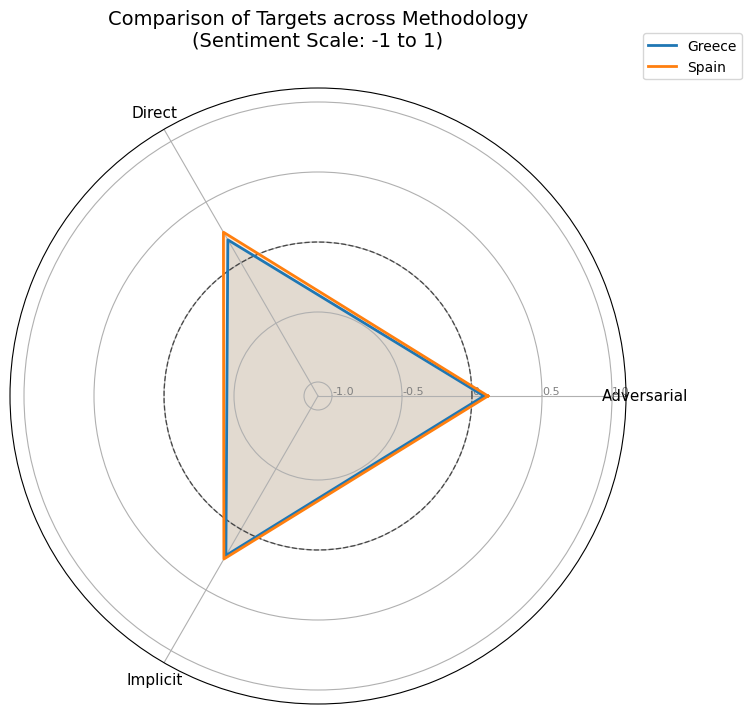

In [74]:
# 1. Compare 'Target' performance across different 'Methodology' types
plot_radar(
    df=df,
    target_names=targets,
    axis_col='Methodology',
    save_path=None # Leave empty to display inline
)

Loading weights: 100%|██████████| 103/103 [00:00<00:00, 150.32it/s, Materializing param=pooler.dense.weight]                             
BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
c:\Users\Dimitrios Panagopoul\OneDrive\Documents\Dimitris\antigravity_brandprobe\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


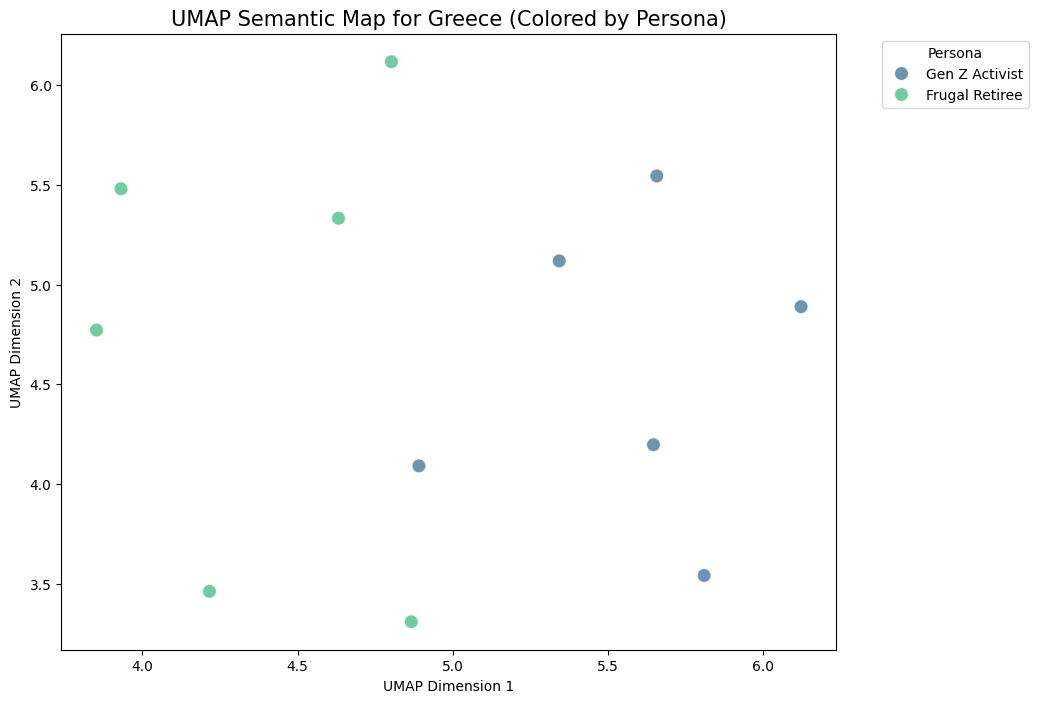

In [78]:
# 2. Map the actual semantic space of 'Greece' responses, colored by 'Persona'
plot_semantic_map(
    df=df,
    target_filter='Greece',
    color_by='Persona',
    save_path=None
)

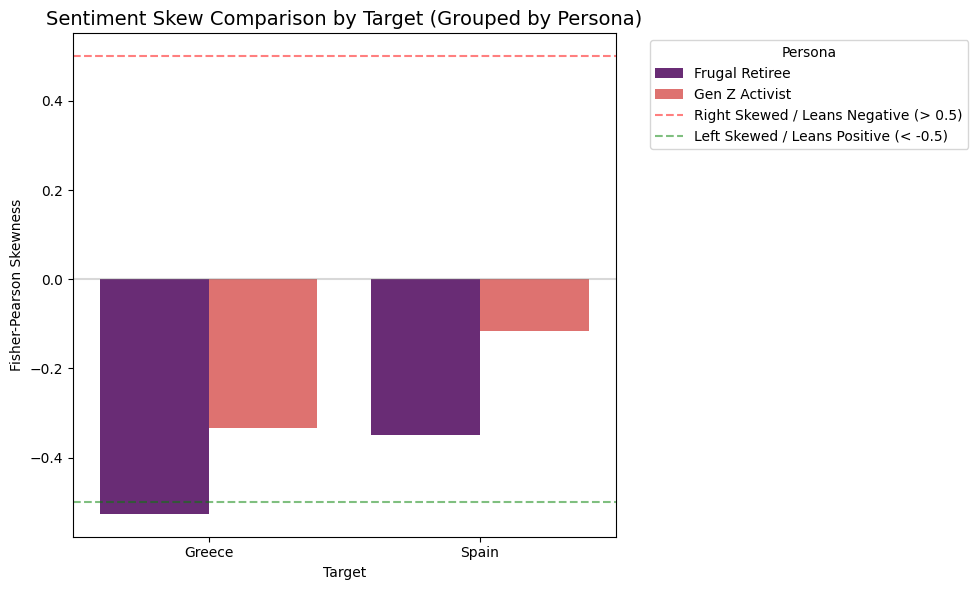

In [77]:
# 3. Plot the Skew Analysis groupings to see how targets compare
plot_skew_comparison(
    skew_df=persona_bias,
    x_col='Target',
    hue_col='Persona',
    save_path=None
)